# Moving Average Smoothing

Smoothing is a technique applied to time series to remove the fine-grained variation between time steps. Calculating a moving average involves creating a new series where the values are comprised of the average of raw observations in the original time series.

A moving average requires that you specify a window size called the window width. This defines the number of raw observations used to calculate the moving average value. 

There are two main types of moving average that are used: 

- **Centered Moving Average**: The value at time *t* is calculated as the average of *t-1*, *t*, and *t+1*. This method requires knowledge of future values, and as such is used on time series analysis to better understand the dataset. It cannot be used to create a feature for modeling.
- **Trailing Moving Average**: The value at time *t* is calculated as the average of *t*, *t-1*, and *t-2*. This only uses historical observations and can therefore be used in forecasting.

## Assumptions
It is assumed that both trend and seasonal components have been removed from your time series
- Time series is stationary, or does not show obvious trends or seasonality

##  Moving Average as Data Preparation

A moving average can be used to create a smoothed version of the original dataset. This can reduce the random variation in the observations and better exposure the structure of the underlying causal processes.

The `rolling()` function in Pandas will automatically group observations into a window.
    

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
series = pd.read_csv('daily-total-female-births.csv', header=0, index_col=0, parse_dates=True, squeeze=True)

# tail-rolling average transform
rolling = series.rolling(window=3)
rolling_mean = rolling.mean()
rolling_mean

Date
1959-01-01          NaN
1959-01-02          NaN
1959-01-03    32.333333
1959-01-04    31.000000
1959-01-05    35.000000
                ...    
1959-12-27    38.333333
1959-12-28    41.000000
1959-12-29    45.666667
1959-12-30    51.666667
1959-12-31    51.000000
Name: Births, Length: 365, dtype: float64

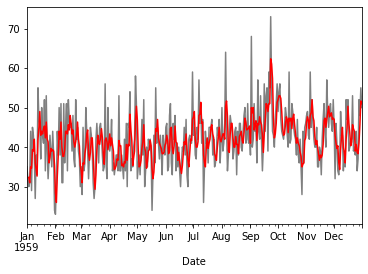

In [3]:
# plot original and transformed dataset
series.plot(color='grey')
rolling_mean.plot(color='red')
plt.show()

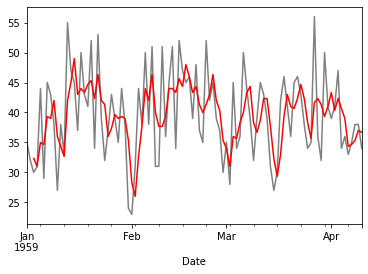

In [4]:
# zoomed plot original and transformed dataset
series[:100].plot(color='grey')
rolling_mean[:100].plot(color='red')
plt.show()

## Moving Average as Feature Engineering

The moving average can be calculated and added as a new input feature used to predict the next time step. 

First, a copy of the series must be shifted forward by one time step. 

Next, a second copy of the series needs to be shifted forward by one, minus the window size. This is to ensure that the moving average summarizes the last few values but does not include the value to be predicted in the average.

In [5]:
df = pd.DataFrame(series.values)
df.head()

,0
0,35
1,32
2,30
3,31
4,44


In [6]:
width = 3
lag1 = df.shift(1)
lag1.head()

,0
0,NaN
1,35.0
2,32.0
3,30.0
4,31.0


In [7]:
lag3 = df.shift(width - 1)
lag3.head()

,0
0,NaN
1,NaN
2,35.0
3,32.0
4,30.0


In [8]:
window = lag3.rolling(window=width)
window

Rolling [window=3,center=False,axis=0,method=single]

In [9]:
means = window.mean()
means.head()

,0
0,NaN
1,NaN
2,NaN
3,NaN
4,32.333333


In [10]:
df = pd.concat([means, lag1, df], axis=1)
df.columns = ['mean', 't', 't+1']
df.head()

,mean,t,t+1
0,NaN,NaN,35
1,NaN,35.0,32
2,NaN,32.0,30
3,NaN,30.0,31
4,32.333333,31.0,44


In the example above, `mean` is calculating the last three values of `t`. Due to the shifting required to effectively create the `t+1` column, it is not until the 5th row that we have enough data to create the first value for the `mean` column. 

## Moving Average as Prediction

This is a naive model that assumes the trend and seasonality components of the time series have already been removed or adjusted for. 

In [11]:
import math
import numpy as np
from sklearn.metrics import mean_squared_error

In [12]:
series = pd.read_csv('daily-total-female-births.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
series

Date
1959-01-01    35
1959-01-02    32
1959-01-03    30
1959-01-04    31
1959-01-05    44
              ..
1959-12-27    37
1959-12-28    52
1959-12-29    48
1959-12-30    55
1959-12-31    50
Name: Births, Length: 365, dtype: int64

In [13]:
# prepare situation
X = series.values
X[:5]

array([35, 32, 30, 31, 44])

In [14]:
window = 3
history = [X[i] for i in range(window)]
history

[35, 32, 30]

In [15]:
test = [X[i] for i in range(window, len(X))]
test[:5]

[31, 44, 29, 45, 43]

In [16]:
predictions = list()

# walk forward over time steps in test
for t in range(len(test)):
    print(f"History = {history}")
    length = len(history)
    print(f'Length of History = {length}')
    yhat = np.mean([history[i] for i in range(length-window, length)])
    print(f'yhat = {[history[i] for i in range(length-window, length)]}')
    print(f'yhat mean = {yhat}')
    obs = test[t]
    print(f'obs = {test[t]}')
    print('Appending yhat...')
    predictions.append(yhat)
    print(f'predictions = {predictions}')
    print('Appending history...')
    history.append(obs)
    print(f'Updated history = {history}')
    print('predicted (moving average)=%f, actual=%f' % (yhat, obs))
    print('\n')

History = [35, 32, 30]
Length of History = 3
yhat = [35, 32, 30]
yhat mean = 32.333333333333336
obs = 31
Appending yhat...
predictions = [32.333333333333336]
Appending history...
Updated history = [35, 32, 30, 31]
predicted (moving average)=32.333333, actual=31.000000


History = [35, 32, 30, 31]
Length of History = 4
yhat = [32, 30, 31]
yhat mean = 31.0
obs = 44
Appending yhat...
predictions = [32.333333333333336, 31.0]
Appending history...
Updated history = [35, 32, 30, 31, 44]
predicted (moving average)=31.000000, actual=44.000000


History = [35, 32, 30, 31, 44]
Length of History = 5
yhat = [30, 31, 44]
yhat mean = 35.0
obs = 29
Appending yhat...
predictions = [32.333333333333336, 31.0, 35.0]
Appending history...
Updated history = [35, 32, 30, 31, 44, 29]
predicted (moving average)=35.000000, actual=29.000000


History = [35, 32, 30, 31, 44, 29]
Length of History = 6
yhat = [31, 44, 29]
yhat mean = 34.666666666666664
obs = 45
Appending yhat...
predictions = [32.333333333333336, 31.

yhat = [46, 64, 45]
yhat mean = 51.666666666666664
obs = 34
Appending yhat...
predictions = [32.333333333333336, 31.0, 35.0, 34.666666666666664, 39.333333333333336, 39.0, 42.0, 36.0, 34.333333333333336, 32.666666666666664, 42.0, 45.0, 49.0, 43.0, 44.0, 43.333333333333336, 44.666666666666664, 45.333333333333336, 42.333333333333336, 46.333333333333336, 42.0, 41.333333333333336, 36.0, 37.333333333333336, 39.666666666666664, 39.0, 39.333333333333336, 39.0, 35.333333333333336, 28.333333333333332, 26.0, 32.666666666666664, 37.666666666666664, 44.0, 42.0, 46.333333333333336, 40.0, 37.666666666666664, 37.666666666666664, 39.333333333333336, 44.0, 44.0, 43.333333333333336, 45.666666666666664, 44.333333333333336, 48.0, 46.0, 43.333333333333336, 44.333333333333336, 41.333333333333336, 40.0, 41.333333333333336, 43.0, 46.333333333333336, 42.0, 40.333333333333336, 35.333333333333336, 34.0, 31.0, 36.0, 35.666666666666664, 38.333333333333336, 40.0, 43.333333333333336, 44.333333333333336, 38.3333333333

predictions = [32.333333333333336, 31.0, 35.0, 34.666666666666664, 39.333333333333336, 39.0, 42.0, 36.0, 34.333333333333336, 32.666666666666664, 42.0, 45.0, 49.0, 43.0, 44.0, 43.333333333333336, 44.666666666666664, 45.333333333333336, 42.333333333333336, 46.333333333333336, 42.0, 41.333333333333336, 36.0, 37.333333333333336, 39.666666666666664, 39.0, 39.333333333333336, 39.0, 35.333333333333336, 28.333333333333332, 26.0, 32.666666666666664, 37.666666666666664, 44.0, 42.0, 46.333333333333336, 40.0, 37.666666666666664, 37.666666666666664, 39.333333333333336, 44.0, 44.0, 43.333333333333336, 45.666666666666664, 44.333333333333336, 48.0, 46.0, 43.333333333333336, 44.333333333333336, 41.333333333333336, 40.0, 41.333333333333336, 43.0, 46.333333333333336, 42.0, 40.333333333333336, 35.333333333333336, 34.0, 31.0, 36.0, 35.666666666666664, 38.333333333333336, 40.0, 43.333333333333336, 44.333333333333336, 38.333333333333336, 36.666666666666664, 38.666666666666664, 42.333333333333336, 42.33333333

In [17]:
pd.DataFrame({"predictions":predictions, "actual":test})

,predictions,actual
0,32.333333,31
1,31.000000,44
2,35.000000,29
3,34.666667,45
4,39.333333,43
...,...,...
357,38.666667,37
358,38.333333,52
359,41.000000,48
360,45.666667,55


Test RMSE: 7.834


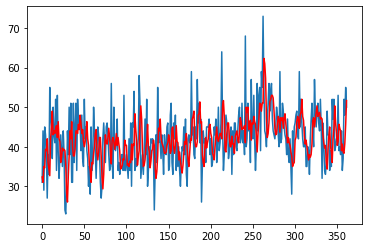

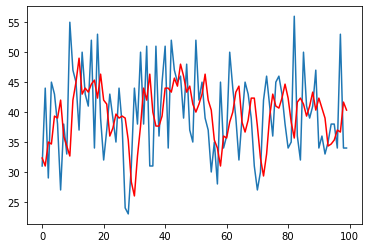

In [18]:
rmse = math.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

# plot
plt.plot(test)
plt.plot(predictions, color = 'red')
plt.show()

# zoom plot
plt.plot(test[:100])
plt.plot(predictions[:100], color = 'red')
plt.show()